In [177]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [178]:
#### Preprocecing ###

In [179]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [180]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [181]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [182]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]


In [183]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]


In [184]:
removed = recovered + death

In [185]:
### Data Preparation ###

In [186]:
S = confirmed.values
R = removed.values
L=5
repeat=10000
iter=10000

In [187]:
data = {'T': S.shape[0], 'N': S.shape[1], 'L': L, 'S': S, 'R': R}

In [188]:
### Model ###

In [189]:
sm = pystan.StanModel(file="covid19.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_50906100ea65def1bb79b367af098c95 NOW.


In [190]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [191]:
### Simulation and Visualization functions ###

In [192]:
T = S.shape[0]
N = S.shape[1]
epoch = pd.to_datetime('2020-01-22')

In [260]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizen):
    cumulative = confirmed.loc[start].values
    recovered = removed.loc[start].values
    infected_list = [(confirmed - removed).loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    cumulative_list = [confirmed.loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    for d in range(horizen):
        I = infected_list[-L] @ c * (1 - cumulative_list[-L] / p) + np.sqrt(sigma_S) * np.random.randn(N)
        cumulative = cumulative + np.maximum(I, 0)
        recovered = recovered + a * (cumulative_list[-1] - recovered) + np.sqrt(sigma_R) * np.random.randn(N)
        recovered = np.maximum(recovered, 0)
        infected_list.append(cumulative - recovered)
        cumulative_list.append(cumulative)
        
    infected = pd.DataFrame(infected_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    cumulative = pd.DataFrame(cumulative_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    return infected, cumulative

In [261]:
def draw_infected(fit, start, horizen, country):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    for i in range(repeat):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        infected, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, infected[country]], axis=1)
    graph = pd.DataFrame(index=pd.date_range(epoch - pd.Timedelta(days=L), 
                                             start + pd.Timedelta(days=horizen), freq='D'))
    real = (confirmed - removed)[country]
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2)

In [262]:
### Validation ###

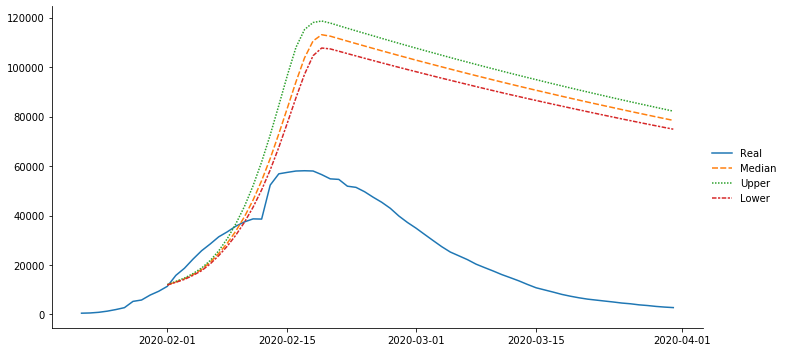

In [263]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'China')

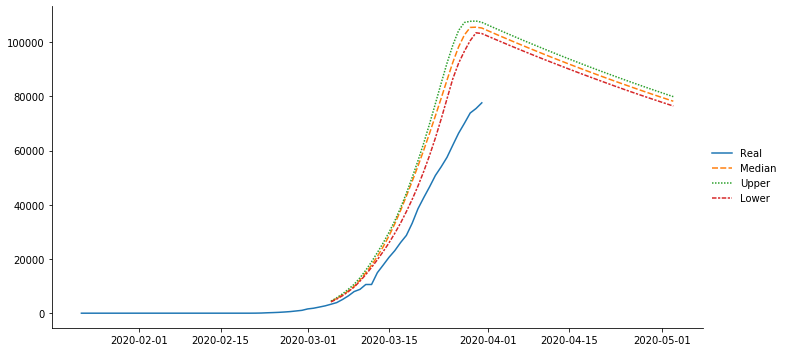

In [264]:
draw_infected(fit, pd.to_datetime('2020-03-5'), 60, 'Italy')

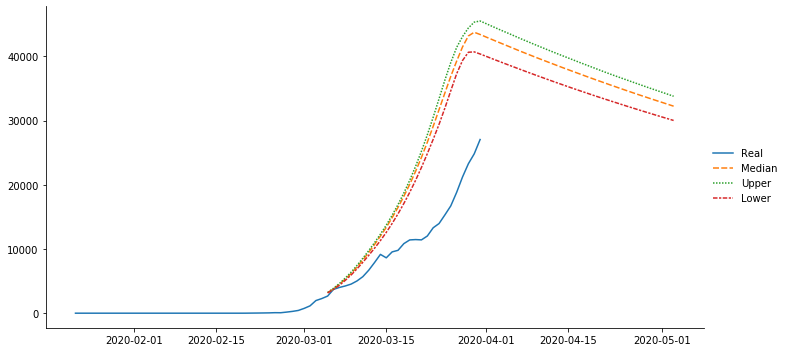

In [265]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Iran')

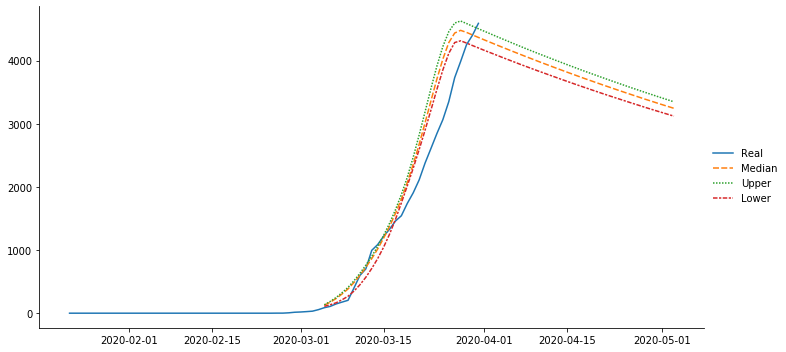

In [266]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Norway')

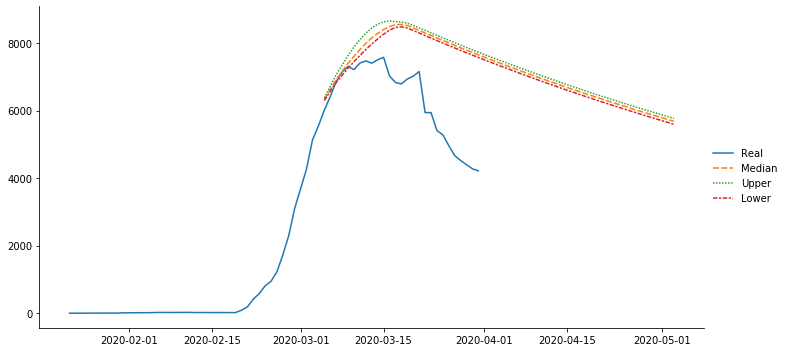

In [267]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Korea, South')

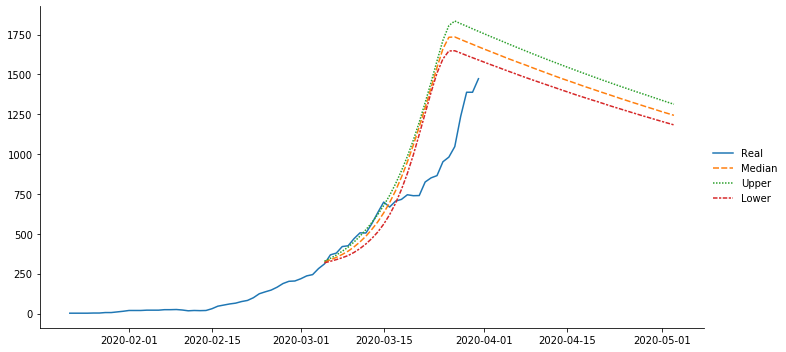

In [268]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Japan')

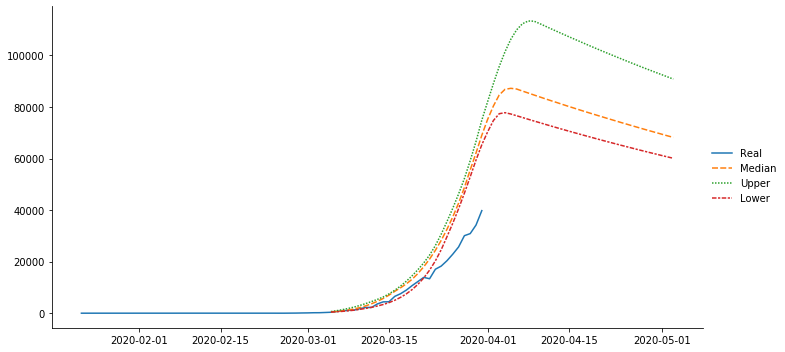

In [269]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'France')

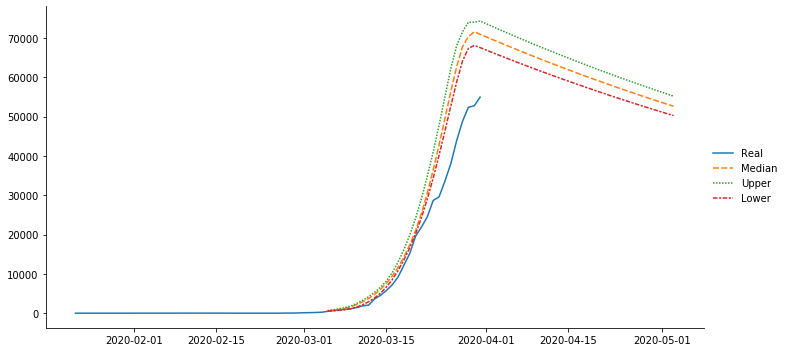

In [270]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Germany')

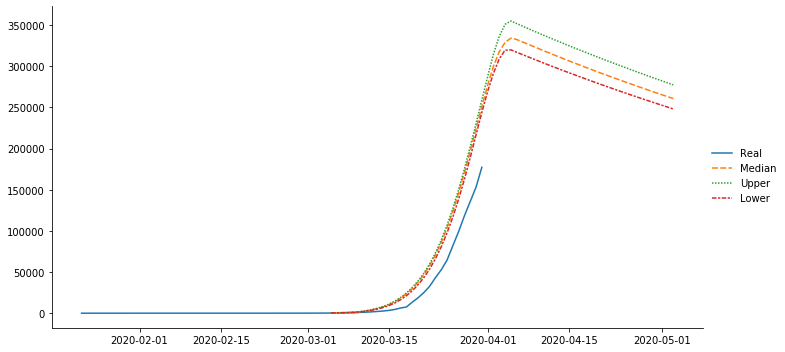

In [271]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'US')

In [272]:
### Prediction ###

In [273]:
recent = confirmed.index[-1]


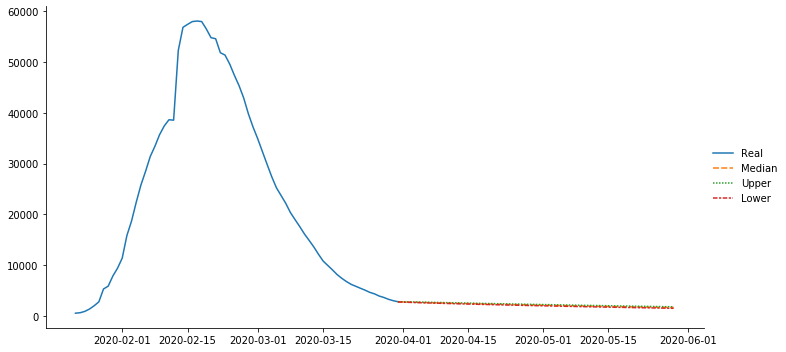

In [274]:
draw_infected(fit, recent, 60, 'China')

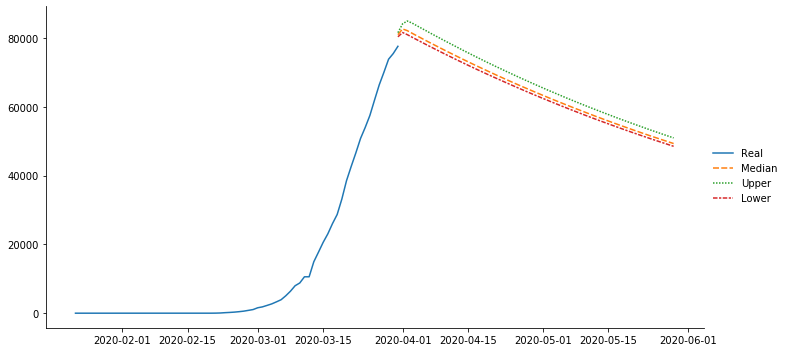

In [275]:
draw_infected(fit, recent, 60, 'Italy')

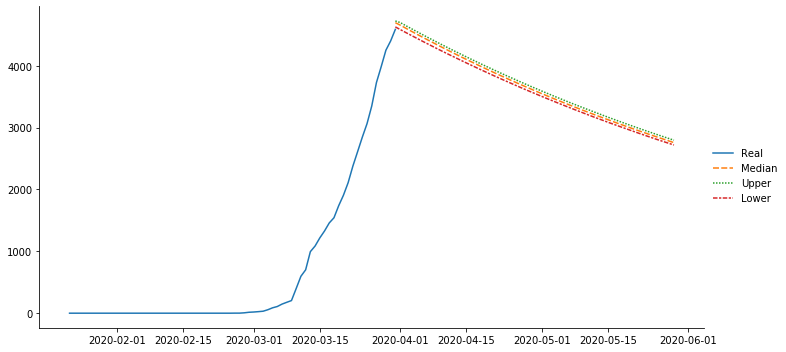

In [276]:
draw_infected(fit, recent, 60, 'Norway')

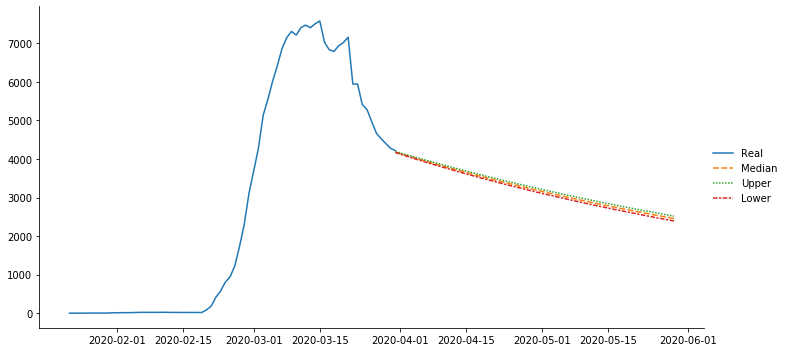

In [277]:
draw_infected(fit, recent, 60, 'Korea, South')

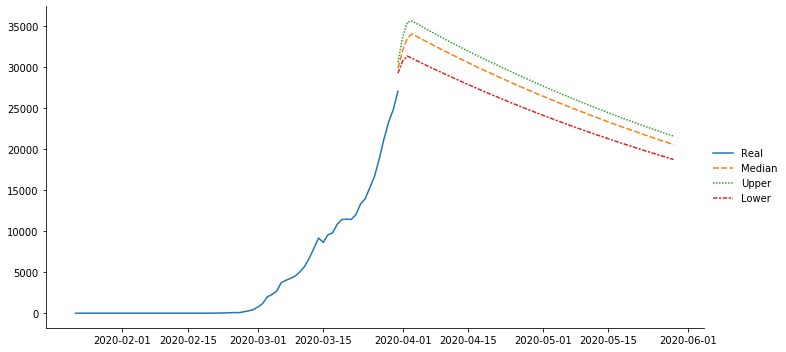

In [278]:
draw_infected(fit, recent, 60, 'Iran')

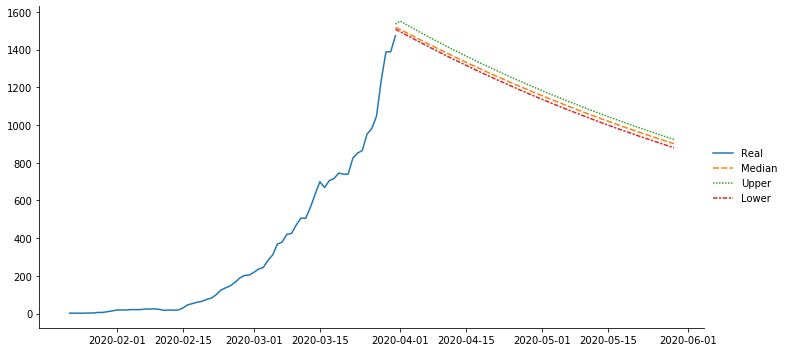

In [279]:
draw_infected(fit, recent, 60, 'Japan')

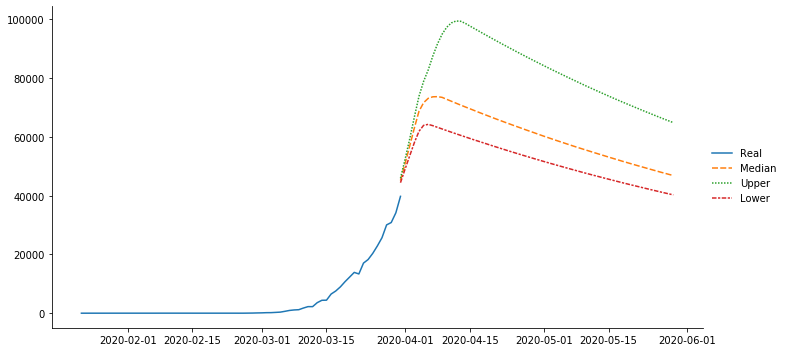

In [280]:
draw_infected(fit, recent, 60, 'France')

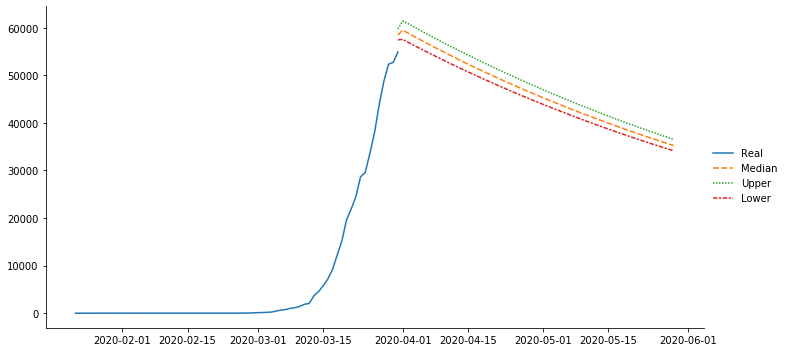

In [281]:
draw_infected(fit, recent, 60, 'Germany')

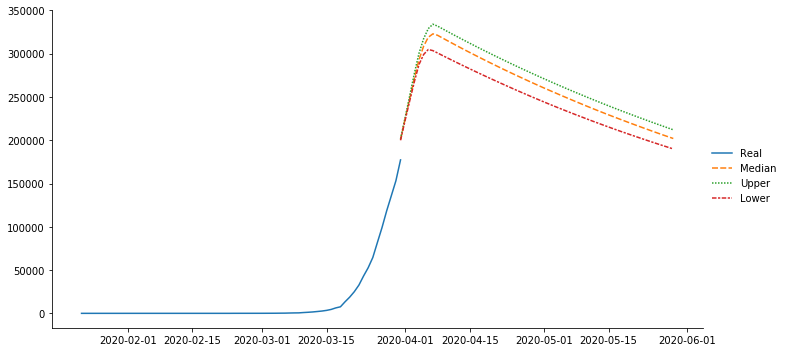

In [282]:
draw_infected(fit, recent, 60, 'US')

In [283]:
def draw_infected_world(fit, start, horizen):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    cum = []
    for i in range(repeat):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        infected, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, infected.sum(axis=1)], axis=1)
        cum.append(cumulative.sum(axis=1).iloc[-1])
    cum = pd.Series(cum)
    graph = pd.DataFrame(index=pd.date_range('2020-01-22', start + pd.Timedelta(days=horizen)))
    real = (confirmed - removed).sum(axis=1)
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2);
    print("Upper:{}, Median:{}, Lower:{}".format(cum.quantile(q=0.75), cum.median(), cum.quantile(q=0.25)))

Upper:1294647.4499607824, Median:1277775.8936728952, Lower:1176656.472240614


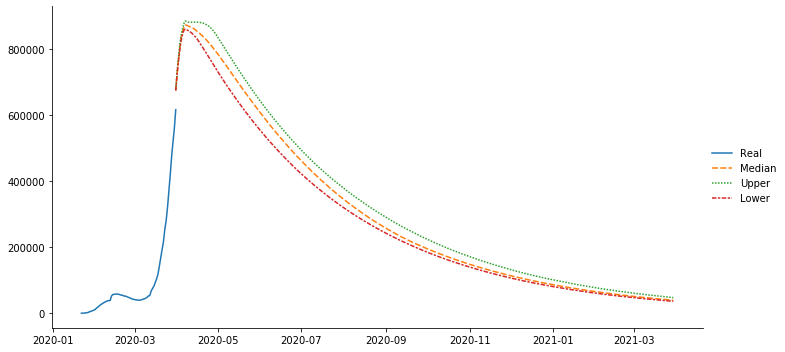

In [284]:
draw_infected_world(fit, recent, 365)

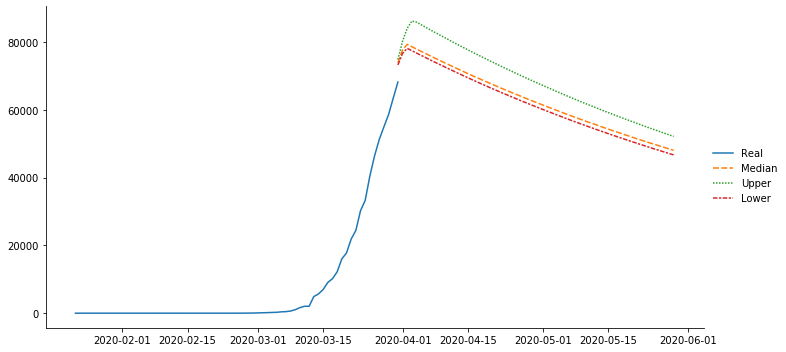

In [285]:
draw_infected(fit, recent, 60, 'Spain')

In [286]:
confirmed.columns

Index(['Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada',
       'Chile', 'China', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador',
       'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Korea, South', 'Luxembourg', 'Malaysia', 'Mexico', 'Netherlands',
       'Norway', 'Pakistan', 'Panama', 'Peru', 'Philippines', 'Poland',
       'Portugal', 'Romania', 'Russia', 'Saudi Arabia', 'South Africa',
       'Spain', 'Sweden', 'Switzerland', 'Thailand', 'Turkey', 'US',
       'United Kingdom'],
      dtype='object', name='Country/Region')

In [287]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': True}

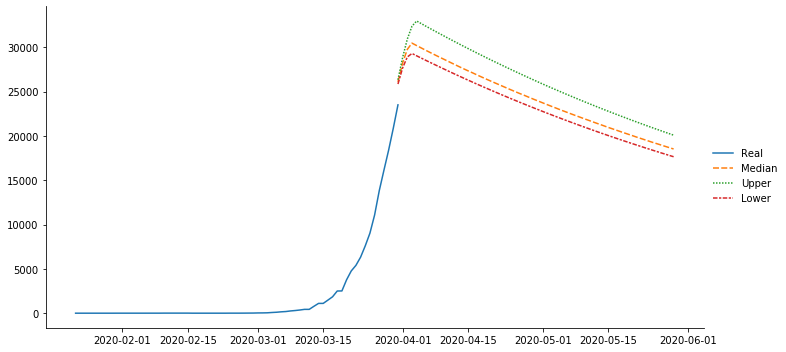

In [288]:
draw_infected(fit, recent, 60, 'United Kingdom')

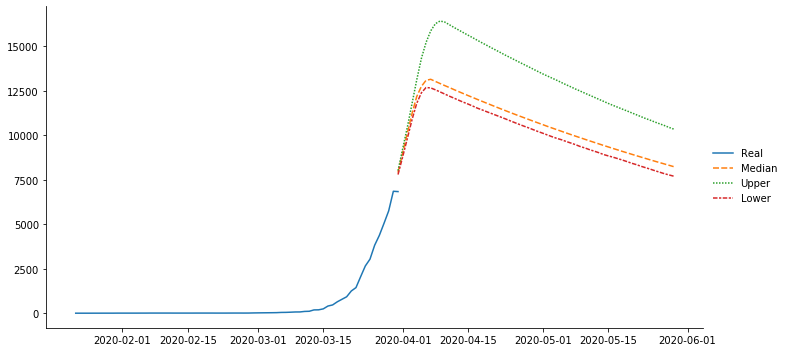

In [289]:
draw_infected(fit, recent, 60, 'Canada')

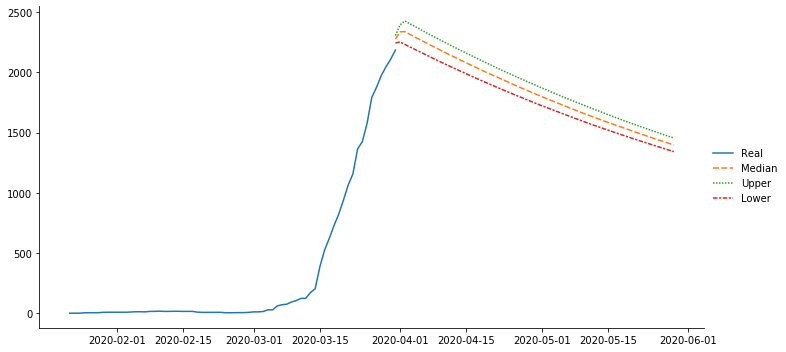

In [290]:
draw_infected(fit, recent, 60, 'Malaysia')

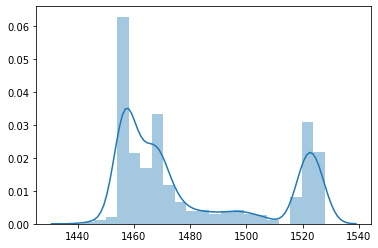

In [291]:
sns.distplot(fit['p'][:,confirmed.columns.get_loc('Japan')])


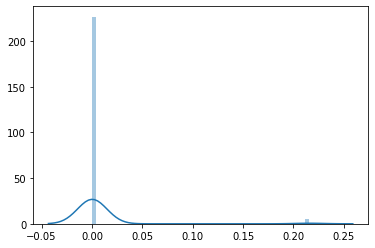

In [292]:
n = confirmed.columns.get_loc('China')
sns.distplot(fit['c'][n,n])

In [293]:
def draw_infected_sums(fit, start, horizen):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    for i in range(repeat):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        _, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, cumulative.iloc[-1]], axis=1)
    melted = pd.melt(data.T).rename(columns={'value':'Infected'})
    my_order = melted.groupby(by=['Country/Region'])['Infected'].median().sort_values(ascending=False).index
    plt.figure(figsize=(10,20))
    sns.boxplot(data=melted, y = 'Country/Region', x='Infected', showfliers=False, order=my_order)
    table = pd.DataFrame({'Lower':data.quantile(q=0.25, axis=1), 
                           'Median':data.median(axis=1), 
                           'Upper':data.quantile(0.75, axis=1)})
    return table

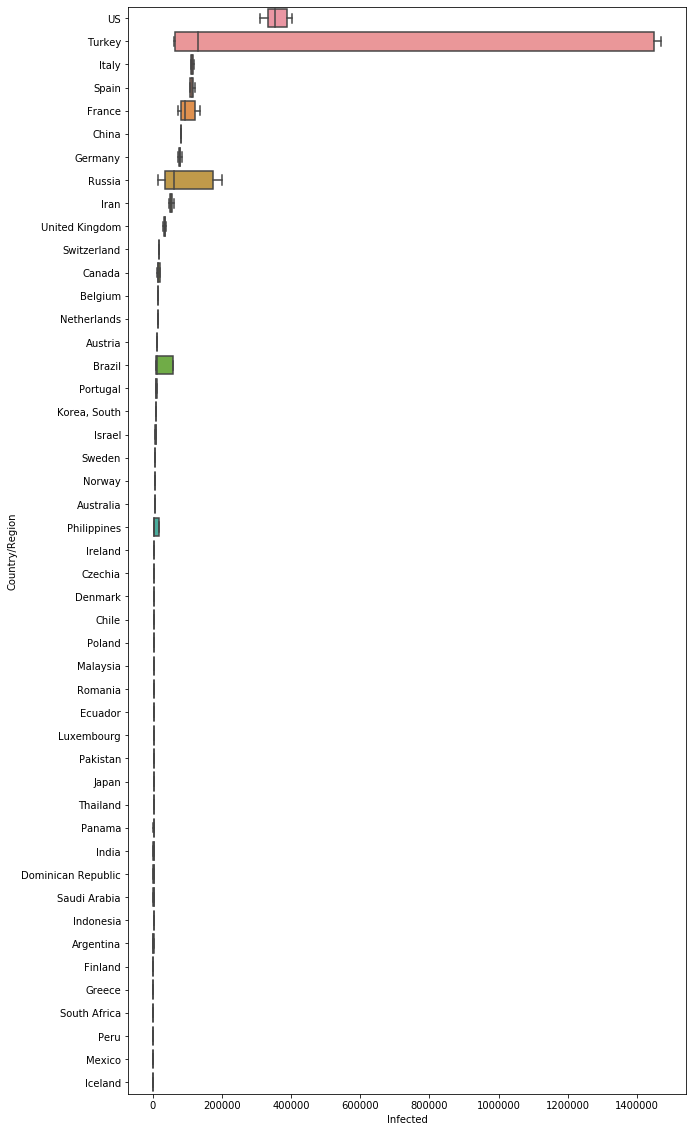

In [294]:
data = draw_infected_sums(fit, recent, 365)

In [295]:
data

,Lower,Median,Upper
Country/Region,,,
Argentina,1442.825383,1573.261390,2.057035e+03
Australia,4729.746482,4765.048140,4.873241e+03
Austria,10713.275977,10757.326992,1.085583e+04
Belgium,13719.860204,13891.915252,1.411875e+04
Brazil,9272.663918,10429.322054,5.809804e+04
Canada,15196.415826,15569.537104,1.931745e+04
Chile,3238.696211,3431.360969,3.499477e+03
China,82279.000000,82279.000000,8.227900e+04
Czechia,3527.728007,3615.516464,3.741395e+03


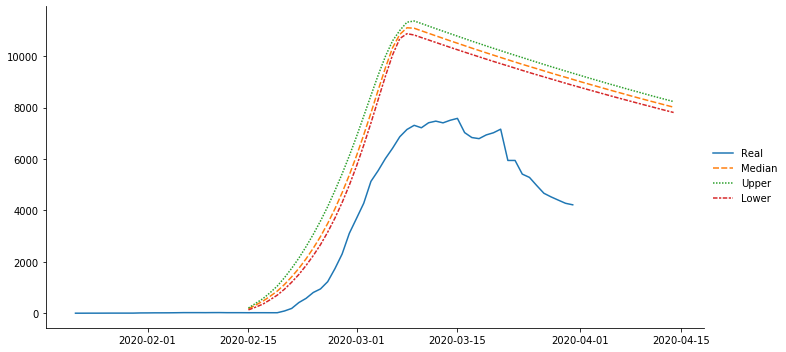

In [296]:
draw_infected(fit, pd.to_datetime('2020-02-15'), 60, 'Korea, South')

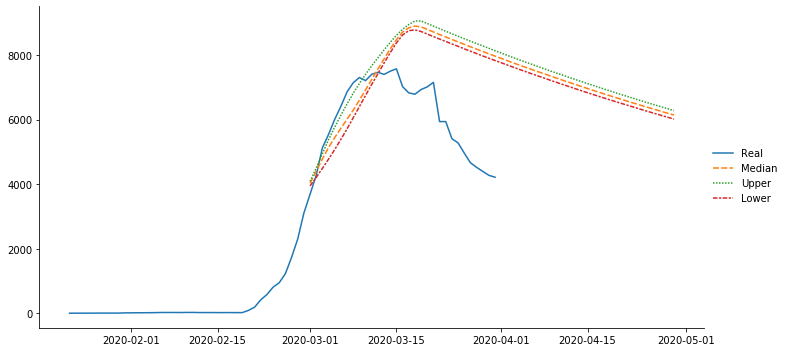

In [297]:
draw_infected(fit, pd.to_datetime('2020-03-01'), 60, 'Korea, South')

In [298]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))

In [299]:
df['Thailand']

2020-01-22       2
2020-01-23       3
2020-01-24       5
2020-01-25       7
2020-01-26       8
              ... 
2020-03-27    1136
2020-03-28    1245
2020-03-29    1388
2020-03-30    1524
2020-03-31    1651
Name: Thailand, Length: 70, dtype: int64

In [300]:
np.sqrt([1, 1, 1])

array([1., 1., 1.])

In [301]:
np.sqrt([1, 1, 1]) * np.random.randn(3)

array([ 0.62755301, -0.94625445, -2.62900661])